# Predicting the Success of a Reddit Submission with Deep Learning and Keras

2016-06-26

by Max Woolf ([@minimaxir](http://minimaxir.com))

*Max's open-source projects are supported by his [Patreon](https://www.patreon.com/minimaxir). If you found this project helpful, any monetary contributions to the Patreon are appreciated and will be put to good creative use.*



BigQuery used to get data:

```sql
#standardSQL 
SELECT id, title,
  CAST(FORMAT_TIMESTAMP('%H', TIMESTAMP_SECONDS(created_utc), 'America/New_York') AS INT64) AS hour,
  CAST(FORMAT_TIMESTAMP('%M', TIMESTAMP_SECONDS(created_utc), 'America/New_York') AS INT64) AS minute,
  CAST(FORMAT_TIMESTAMP('%w', TIMESTAMP_SECONDS(created_utc), 'America/New_York') AS INT64) AS dayofweek,
  CAST(FORMAT_TIMESTAMP('%j', TIMESTAMP_SECONDS(created_utc), 'America/New_York') AS INT64) AS dayofyear,
  IF(PERCENT_RANK() OVER (ORDER BY score ASC) >= 0.50, 1, 0) as is_top_submission
  FROM `fh-bigquery.reddit_posts.*`
  WHERE (_TABLE_SUFFIX BETWEEN '2017_01' AND '2017_04')
  AND subreddit = 'AskReddit'
```

# Setup

In [1]:
import numpy as np
import os
import csv
from random import random, sample, seed
import pandas as pd
from datetime import datetime

data_path = '../ErdosInstitute-SIG_Project/Data/wsb_full.csv'
embeddings_path = '../ErdosInstitute-SIG_Project/Data/glove.6B.50d.txt'

In [2]:
#for now, we follow Woolf
#let's keep the removed/deleted posts and only look at titles
dfog = pd.read_csv(data_path, low_memory=False)
#dfog=dfog.loc[((dfog.is_self==True) & ~(dfog["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False)))]
#df=dfog.dropna(subset = ['title'])
dfog=dfog.loc[(((dfog.removed_by_category.isnull()))) & ((dfog.is_self==True) & ~(dfog["title"].str.contains("Thread|thread|Sunday Live Chat|consolidation zone|Containment Zone|Daily Discussion|Daily discussion|Saturday Chat|What Are Your Moves Tomorrow|What Are Your Moves Today|MEGATHREAD",na=False)))]
df=dfog.dropna(subset = ['title', 'selftext'])

In [3]:
df['utc']=df.created_utc.apply(lambda x : datetime.utcfromtimestamp(x))
df['utc']

<ipython-input-3-75e8bc7c8810>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['utc']=df.created_utc.apply(lambda x : datetime.utcfromtimestamp(x))


2         2020-01-01 23:50:05
7         2020-01-01 23:05:40
10        2020-01-01 22:55:13
15        2020-01-01 22:15:00
27        2020-01-01 21:20:32
                  ...        
1259949   2021-05-06 03:14:29
1260007   2021-05-06 02:36:54
1260046   2021-05-06 02:13:08
1260101   2021-05-06 01:38:25
1260232   2021-05-06 00:02:57
Name: utc, Length: 53847, dtype: datetime64[ns]

In [4]:
def GoodPost(ups,threshold=1):
    if ups>threshold:
        return 1
    return 0

In [57]:
#titles = []
#hours = []
#minutes = []
#dayofweeks = []
#dayofyears = []
#is_top_submission = []

#with open(data_path, 'r', encoding="latin1") as f:
#    reader = csv.DictReader(f)
#    for submission in reader:
#        titles.append(submission['title'])
#        hours.append(submission['hour'])
#        minutes.append(submission['minute'])
#        dayofweeks.append(submission['dayofweek'])
#        dayofyears.append(submission['dayofyear'])
#        is_top_submission.append(submission['is_top_submission'])

#might want to consider trying to get above median, rather than trying to get above 1. But let's see.
#ups_median=np.median(df.ups)
            
titles = np.array(df.title)
selftexts=np.array(df.selftext)
hours = np.array(df.utc.apply(lambda x : x.hour), dtype=int)
minutes = np.array(df.utc.apply(lambda x : x.minute), dtype=int)
dayofweeks = np.array(df.utc.apply(lambda x : x.weekday()), dtype=int)
dayofyears = np.array(df.utc.apply(lambda x : x.timetuple().tm_yday), dtype=int)
is_top_submission = np.array(df.ups.apply(lambda x : GoodPost(x)), dtype=int)

In [58]:
print(titles[0:2])
print(titles.shape)
print(selftexts[0:2])
print(selftexts.shape)
print(hours[0:2])
print(minutes[0:2])
print(dayofweeks[0:2])
print(dayofyears[0:2])
print(is_top_submission[0:2])
print(titles[-4])

['Buy INTU - DD' 'New Years Challenge: 5K Make-it or Break-it']
(53847,)
['https://www.schaeffersresearch.com/content/analysis/2019/12/31/intu-options-traders-positioned-for-upside\n\nThis on Google.  Buy buy buy.'
 "Alright WSB,\n\nSo I recently came into about 5k due to some nice work stuff. I have very, very little knowledge of investments but I want to do something with it and thought I'd make it a fun game.\n\nPlease tell me where these dollars should go. Whatever suggestion, no matter how crazy, I'll consider.  Whichever comment gets the most upvotes is what I'll do. To that person: I'll give you half of whatever I make at the end of January. If we strike big, we strike big together. If it's a bust, it's all your fault and how dare you.\n\nLet's start this year off right with some dumb gambles!"]
(53847,)
[23 23]
[50  5]
[2 2]
[1 1]
[1 1]
👀👑 Opportunity in SKLZ - Hear Me Out


In [59]:
df.selftext

2          https://www.schaeffersresearch.com/content/ana...
7          Alright WSB,\n\nSo I recently came into about ...
10         I saw an older thread on it, curious who is st...
15         First day of legal weed in Illinois, passed by...
27         I was going to tag this as technical, but sinc...
                                 ...                        
1259949    **Overview**\n\nEDIT 2: position= 56 shares at...
1260007    🚨UPDATE: FREE float being gobbled up by Cathie...
1260046    Just a quick note so you may understand the va...
1260101    What fucking part of that do you still not und...
1260232    good evening apes, fellow smooth brains\n\nfir...
Name: selftext, Length: 53847, dtype: object

In [60]:
1 - np.mean(is_top_submission)

0.09686704923208345

In [9]:
#np.median(list(df.ups))

The No-Information Rate is 64% (i.e. simply say all AskReddit submissions are terrible), so any model trained must do better than that.

# Process /r/AskReddit Submission Title Text

In [61]:
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence, Tokenizer

max_features = 40000

word_tokenizer = Tokenizer(max_features)
word_tokenizer.fit_on_texts(titles)

#selftext version
word_tokenizer_selftexts = Tokenizer(max_features)
word_tokenizer_selftexts.fit_on_texts(selftexts)

print(str(word_tokenizer.word_counts)[0:100])
print(str(word_tokenizer.word_index)[0:100])
print(len(word_tokenizer.word_counts))   # true word count
print(str(word_tokenizer_selftexts.word_counts)[0:100])
print(str(word_tokenizer_selftexts.word_index)[0:100])
print(len(word_tokenizer_selftexts.word_counts))   # true word count

OrderedDict([('buy', 2851), ('intu', 2), ('dd', 1739), ('new', 912), ('years', 123), ('challenge', 2
{'the': 1, 'to': 2, 'is': 3, 'and': 4, 'a': 5, 'on': 6, 'for': 7, 'of': 8, 'gme': 9, 'in': 10, 'i': 
24511
OrderedDict([('https', 54441), ('www', 23512), ('schaeffersresearch', 6), ('com', 40852), ('content'
{'the': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'is': 6, 'in': 7, 'i': 8, 'for': 9, 'this': 10, 'that
168720


In [62]:
titles_tf = word_tokenizer.texts_to_sequences(titles)
selftexts_tf = word_tokenizer_selftexts.texts_to_sequences(selftexts)

print(titles_tf[0])
print(selftexts_tf[0])

[15, 8927, 31]
[16, 50, 27681, 26, 813, 739, 405, 192, 721, 22601, 151, 681, 2766, 9, 1018, 10, 13, 518, 56, 56, 56]


In [63]:
maxlen = 20
maxlen_selftexts = 20
titles_tf = sequence.pad_sequences(titles_tf, maxlen=maxlen)
selftexts_tf = sequence.pad_sequences(selftexts_tf,maxlen=maxlen_selftexts)

print(titles_tf[0])
print(selftexts_tf[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   15 8927   31]
[   50 27681    26   813   739   405   192   721 22601   151   681  2766
     9  1018    10    13   518    56    56    56]


## Add Pretrained Embeddings

Adapted from [the official keras tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

Use pretrained GloVe embeddings to both give Embeddings training a good start, and to account for words that might be present in the test set but not in the training set.

First, load the 50D embeddings into memory.

In [64]:
embedding_vectors = {}

with open(embeddings_path, 'r',encoding='latin-1') as f:
    for line in f:
        #print(line)
        line_split = line.strip().split(" ")
        vec = np.array(line_split[1:], dtype=float)
        word = line_split[0]
        embedding_vectors[word] = vec
        
print(embedding_vectors['you'])

[-1.0919e-03  3.3324e-01  3.5743e-01 -5.4041e-01  8.2032e-01 -4.9391e-01
 -3.2588e-01  1.9972e-03 -2.3829e-01  3.5554e-01 -6.0655e-01  9.8932e-01
 -2.1786e-01  1.1236e-01  1.1494e+00  7.3284e-01  5.1182e-01  2.9287e-01
  2.8388e-01 -1.3590e+00 -3.7951e-01  5.0943e-01  7.0710e-01  6.2941e-01
  1.0534e+00 -2.1756e+00 -1.3204e+00  4.0001e-01  1.5741e+00 -1.6600e+00
  3.7721e+00  8.6949e-01 -8.0439e-01  1.8390e-01 -3.4332e-01  1.0714e-02
  2.3969e-01  6.6748e-02  7.0117e-01 -7.3702e-01  2.0877e-01  1.1564e-01
 -1.5190e-01  8.5908e-01  2.2620e-01  1.6519e-01  3.6309e-01 -4.5697e-01
 -4.8969e-02  1.1316e+00]


Initialize the weights matrix as zeroes, then replace the corresponding index of the weights matrix with the index of the corresponding word.

In [65]:
weights_matrix = np.zeros((max_features + 1, 50))

for word, i in word_tokenizer.word_index.items():

    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None and i <= max_features:
        weights_matrix[i] = embedding_vector

# index 0 vector should be all zeroes, index 1 vector should be the same one as above
print(weights_matrix[0:2,:])

[[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00]
 [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
  -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
  -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
  -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
  -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
   4.0071e+

In [15]:
###selftext version of above
weights_matrix_selftexts = np.zeros((max_features + 1, 50))

for word, i in word_tokenizer_selftexts.word_index.items():

    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None and i <= max_features:
        weights_matrix_selftexts[i] = embedding_vector

# index 0 vector should be all zeroes, index 1 vector should be the same one as above
print(weights_matrix_selftexts[0:2,:])

[[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
   0.0000e+00  0.0000e+00]
 [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
  -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
  -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
  -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
  -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
   4.0071e+

# Process Other Metadata

All metadata must be zero-indexed integers.

* `hours` in the correct format. (`0` = 12AM EST, `23` = 11PM EST)
* `dayofweeks` is in the correct format (`0` = Sunday, `6` = Saturday) (for me 0 is Monday)
* `minutes` is in the correct format verbatim.
* `dayofyears` is 1-indexed, so must subtract 1.

In [66]:
dayofyears_tf = dayofyears - 1

max(dayofyears_tf)

364

# Build the Model

Use Keras's functional API to build a branching model.

In [67]:
from keras.models import Input, Model
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, concatenate, Activation
from keras.layers.core import Masking, Dropout, Reshape
from keras.layers.normalization import BatchNormalization

batch_size = 32
embedding_dims = 50
epochs = 10

## Text Branch

Encode the text using a mock fasttext approach. Use `weights_matrix` derived above.

In [68]:
titles_input = Input(shape=(maxlen,), name='titles_input')
titles_embedding = Embedding(max_features + 1, embedding_dims, weights=[weights_matrix])(titles_input)
titles_pooling = GlobalAveragePooling1D()(titles_embedding)

In [69]:
selftexts_input = Input(shape=(maxlen_selftexts,), name='selftexts_input')
selftexts_embedding = Embedding(max_features + 1, embedding_dims, weights=[weights_matrix_selftexts])(selftexts_input)
selftexts_pooling = GlobalAveragePooling1D()(selftexts_embedding)

Add an auxillary output to regularize the text component.

In [70]:
aux_output = Dense(1, activation='sigmoid', name='aux_out_titles')(titles_pooling)
aux_output_selftexts = Dense(1, activation='sigmoid', name='aux_out_selftexts')(selftexts_pooling)

## Metadata Branch

Each metadata variable gets its own input and Embeddings. (size of each Embedding is already known by construction of the variables)

`Reshape` is necessary to convert from 2D to 1D.

In [71]:
meta_embedding_dims = 64

hours_input = Input(shape=(1,), name='hours_input')
hours_embedding = Embedding(24, meta_embedding_dims)(hours_input)
hours_reshape = Reshape((meta_embedding_dims,))(hours_embedding)

dayofweeks_input = Input(shape=(1,), name='dayofweeks_input')
dayofweeks_embedding = Embedding(7, meta_embedding_dims)(dayofweeks_input)
dayofweeks_reshape = Reshape((meta_embedding_dims,))(dayofweeks_embedding)

minutes_input = Input(shape=(1,), name='minutes_input')
minutes_embedding = Embedding(60, meta_embedding_dims)(minutes_input)
minutes_reshape = Reshape((meta_embedding_dims,))(minutes_embedding)

dayofyears_input = Input(shape=(1,), name='dayofyears_input')
dayofyears_embedding = Embedding(366, meta_embedding_dims)(dayofyears_input)
dayofyears_reshape = Reshape((meta_embedding_dims,))(dayofyears_embedding)

Minutes and dayofyears are single scalars; no need to `Reshape`.

## Merge the Branches and Complete Model

Combine the 5 embeddings (306D total), add a FC layer to understand latent characteristic, output 1 value for logistic regression.

In [72]:
merged = concatenate([titles_pooling, selftexts_pooling, hours_reshape, dayofweeks_reshape, minutes_reshape, dayofyears_reshape])

hidden_1 = Dense(256, activation='relu')(merged)
hidden_1 = BatchNormalization()(hidden_1)

main_output = Dense(1, activation='sigmoid', name='main_out')(hidden_1)

## Compile the Model

In [73]:
model = Model(inputs=[titles_input,
                      selftexts_input,
                      hours_input,
                      dayofweeks_input,
                      minutes_input,
                      dayofyears_input], outputs=[main_output, aux_output, aux_output_selftexts])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              loss_weights=[1, 0.2, 0.2])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
titles_input (InputLayer)       [(None, 20)]         0                                            
__________________________________________________________________________________________________
selftexts_input (InputLayer)    [(None, 20)]         0                                            
__________________________________________________________________________________________________
hours_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
dayofweeks_input (InputLayer)   [(None, 1)]          0                                            
____________________________________________________________________________________________

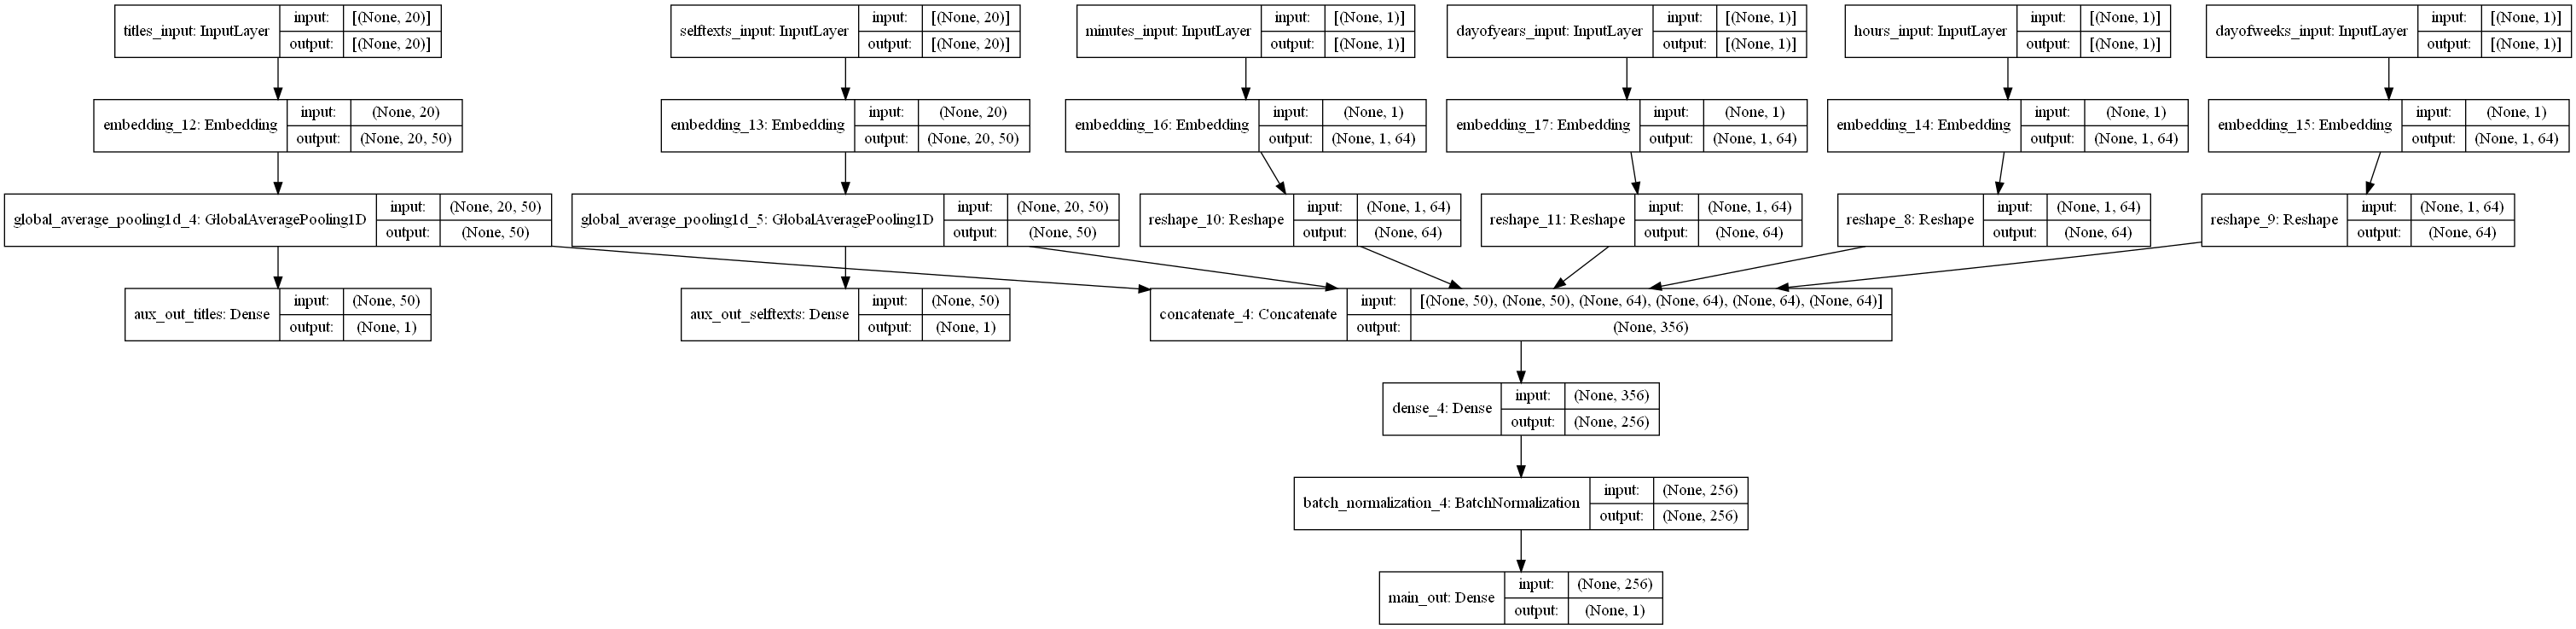

In [74]:
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

![](model.png)

# Train the Model!

Randomize the model before training, since Keras [takes the last 20%](https://keras.io/getting-started/faq/#how-is-the-validation-split-computed) as the validation set.

In [75]:
seed(123)
split = 0.2

# returns randomized indices with no repeats
idx = sample(range(titles_tf.shape[0]), titles_tf.shape[0])

titles_tf = titles_tf[idx, :]
selftexts_tf=selftexts_tf[idx, :]
hours = hours[idx]
dayofweeks = dayofweeks[idx]
minutes = minutes[idx]
dayofyears_tf = dayofyears_tf[idx]
is_top_submission = is_top_submission[idx]

Determine No-Information Rate of the test set: the `val_main_out_acc` must be better than it.

In [76]:
print(1 - np.mean(is_top_submission[:(int(titles_tf.shape[0] * split))]))

0.09750208933048565


Log results to file:

In [77]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training.csv')

Train the model (finally!)

In [79]:
model.fit([titles_tf, selftexts_tf, hours, dayofweeks, minutes, dayofyears_tf], [is_top_submission, is_top_submission, is_top_submission],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=split, callbacks=[csv_logger])

Epoch 1/10


TypeError: 'NoneType' object is not callable

# Using the Model to Make Predictions

Use the created model to optimize a submission to /r/AskReddit.

Example submission with only 4 upvotes: [Which movie's plot would drastically change if you removed a letter from its title?](https://www.reddit.com/r/AskReddit/comments/5odcpd/which_movies_plot_would_drastically_change_if_you/)

## Optimize Text (fixing Time Submitted)

First create a function to include arbitrary text as model-acceptable format. (using dictionary created from the Tokenizer)

In [22]:
def encode_text(text, maxlen):
    encoded = word_tokenizer.texts_to_sequences([text])
    return sequence.pad_sequences(encoded, maxlen=maxlen)

In [36]:
input_text = "Which movie's plot would drastically change if you removed a letter from its title?"
encoded_text = encode_text(input_text, maxlen)
print(encoded_text)

[[   0    0    0    0    0    0   68 6380  923   18 3403  142   23    1
  1513    5 1146   44  302  508]]


Identify a baseline using the real values.

The first value (index 0) is the value from the `main_output`, the second is from the fasttext `aux_output`.

In [37]:
input_hour = np.array([15])
input_minute = np.array([46])
input_dayofweek = np.array([1])
input_dayofyear = np.array([16 - 1])

model.predict([encoded_text, input_hour, input_dayofweek, input_minute, input_dayofyear])

[array([[ 0.66917652]], dtype=float32), array([[ 0.40641001]], dtype=float32)]

So can see if we can to perform better than 0.67 probability. Make minor changes without avertly changing meaning.

In [38]:
input_text = "Which movie's plot would change if you removed a letter from its title?"
encoded_text = encode_text(input_text, maxlen)
model.predict([encoded_text, input_hour, input_dayofweek, input_minute, input_dayofyear])

[array([[ 0.68286121]], dtype=float32), array([[ 0.40531182]], dtype=float32)]

Removing "drastically" makes things better.

How about fixing the tense of "removed"?

In [41]:
input_text = "Which movie's plot would change if you remove a letter from its title?"
encoded_text = encode_text(input_text, maxlen)
model.predict([encoded_text, input_hour, input_dayofweek, input_minute, input_dayofyear])

[array([[ 0.69150311]], dtype=float32), array([[ 0.4588666]], dtype=float32)]

Probability increased. From that headline, how about changing "Which" to "What?"

In [42]:
input_text = "What movie's plot would change if you remove a letter from its title?"
encoded_text = encode_text(input_text, maxlen)
model.predict([encoded_text, input_hour, input_dayofweek, input_minute, input_dayofyear])

[array([[ 0.7321561]], dtype=float32), array([[ 0.51213974]], dtype=float32)]

What about using more emphasis: add "single" to letter.

In [44]:
input_text = "What movie's plot would change if you remove a single letter from its title?"
encoded_text = encode_text(input_text, maxlen)
model.predict([encoded_text, input_hour, input_dayofweek, input_minute, input_dayofyear])

[array([[ 0.75322324]], dtype=float32), array([[ 0.55223811]], dtype=float32)]

## Optimize Time Submitted (fixing Text)

Do a hyperparameter grid search for all combinations of `hour`, `minute`, and `dayofweek` (`dayofyear` must be offset accordingly with `dayofweek`) and record the probabilities.

In [45]:
results_array = []

for input_dayofweek in range(6):
    for input_hour in range(23):
        for input_minute in range(59):
            results_array.append([input_dayofweek,
                                  input_hour,
                                  input_minute,
                                  model.predict([encoded_text,
                                                 np.array([input_hour]),
                                                 np.array([input_dayofweek]),
                                                 np.array([input_minute]),
                                                 input_dayofyear + input_dayofweek - 1])[0]])
            
results_array = np.array(results_array)

In [47]:
print(results_array[results_array[:,3].argsort()[::-1]][0:20,:])

[[  0.          22.          55.           0.84148395]
 [  0.          22.          13.           0.83928609]
 [  0.          22.           0.           0.83868033]
 [  0.          22.          49.           0.83778793]
 [  0.          22.          27.           0.83483583]
 [  0.          22.          19.           0.83461344]
 [  0.          22.          16.           0.83399975]
 [  0.          22.          39.           0.83264273]
 [  0.          22.          47.           0.82798171]
 [  0.          22.          33.           0.82755792]
 [  0.          22.          43.           0.82691711]
 [  0.          22.          42.           0.82675755]
 [  0.          22.          58.           0.82663274]
 [  0.          22.          10.           0.82661295]
 [  0.          22.          37.           0.82582957]
 [  0.          22.          25.           0.82406569]
 [  0.          22.          12.           0.82374126]
 [  0.          21.          13.           0.82372391]
 [  2.    

# Extract Embeddings

Add the embeddings for each Embeddings layer into a .txt file. (skipping word vectors, since the resulting data file will be huge.

Create a helper function to do that:

In [31]:
def write_embeddings(weights, file_name):
    f = open(file_name + ".txt", 'w')
    for i in range(weights.shape[0]):
            f.write(str(i) + " " + " ".join(str(x) for x in weights[i]) + "\n")
    f.close()

The layers are in the same order as they were instantiated (can look at summary to get index).

In [32]:
write_embeddings(model.layers[6].get_weights()[0], "hours_embeddings")
write_embeddings(model.layers[7].get_weights()[0], "dayofweeks_embeddings")
write_embeddings(model.layers[8].get_weights()[0], "minutes_embeddings")

# remember to add +1 back to index when doing analysis
# additionally, the last value corresponds to i = 366
write_embeddings(model.layers[9].get_weights()[0], "dayofyears_embeddings")

# LICENSE

The MIT License (MIT)

Copyright (c) 2017 Max Woolf

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.